Explicaciones para NLP utilizando SHAP
======================================

Introducción
------------

La idea detrás de los valores de Shapley (Shapley, Lloyd S 1953) es la siguiente: dado un conjunto de predictores, encontrar la contribución marginal de cada predictor con respecto a la predicción general. ¿cuál es la predicción general? Es el valor esperado del modelo (EV). Piense en ello como la línea de base del modelo. Entonces, la contribución marginal indica en que medida cada predictor obliga a la predicción a alejarse de esa línea de base.

Para una introducción más detallada puede ver la entrada del blog: [Model interpretability — Making your model confesses: SHAP](https://santiagof.medium.com/model-interpretability-making-your-model-confess-shapley-values-5fb95a10a624)

¿Como funciona?
---------------

La forma en que los valores de Sharpley calculan la contribución marginal es calculando el valor predicho con y sin el valor de la característica que se está considerando actualmente y tomando la diferencia para obtener la contribución marginal. Finalmente, el valor de Sharpley se calcula promediando la contribución marginal del valor de la característica en todos los subconjuntos de características posibles (llamados coaliciones) dentro del conjunto de características en el que participa la característica.

Este algorimo se encuentra implementado en la libraria Shap. Para mas información sobre esta librería visite: https://shap.readthedocs.io/en/latest/index.html

### Para ejecutar este notebook

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Para ejecutar este notebook, instale las siguientes librerias:

In [2]:
!pip install transformers --quiet
!pip install shap --quiet

     |████████████████████████████████| 4.7 MB 6.7 MB/s 
     |████████████████████████████████| 101 kB 10.8 MB/s 
     |████████████████████████████████| 596 kB 44.2 MB/s 
     |████████████████████████████████| 6.6 MB 25.3 MB/s 
     |████████████████████████████████| 569 kB 8.5 MB/s 


Descargaremos un modelo previamente entrenando el el problema de clasificación de Tweets:

In [3]:
!wget https://santiagxf.blob.core.windows.net/public/models/tweet_classification_bert.zip --no-clobber --quiet
!unzip -qq tweet_classification_bert.zip

Cargamos el conjunto de datos con el que se entrenó el modelo en caso de necesitarlo

In [1]:
!wget https://raw.githubusercontent.com/santiagxf/M72109/master/NLP/Datasets/mascorpus/tweets_marketing.csv \
    --quiet --no-clobber --directory-prefix ./Datasets/mascorpus/

In [4]:
import pandas as pd

tweets = pd.read_csv('Datasets/mascorpus/tweets_marketing.csv')

Cargando un modelo de NLP
-------------------------

Recordemos que nuestro modelo predice los sectores a los que pertenecería el tweet, siendo ellos:

In [16]:
target_names = {0:'ALIMENTACION', 1:'AUTOMOCION', 2:'BANCA', 3:'BEBIDAS', 4:'DEPORTES', 5:'RETAIL', 6:'TELCO'}

Cargaremos el modelo que fue descargado anteriornmente utilizando la librería de `transformers`. Note que cargamos tanto el `tokenizer` como el modelo propiamente dicho.

In [27]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "tweet_classification_bert"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                           id2label=target_names, 
                                                           label2id={v:k for k,v in target_names.items()})

> **Tip:** Agregar los parameteros `id2label` y `label2id` permite que el modelo pueda conocer los verdaderos valores de las clases que predice. 

Construimos un pipeline con nuestro modelo y tokenizer

In [28]:
pred = transformers.pipeline("text-classification", model=model, tokenizer=tokenizer, device=-1, top_k=1)

Generando explicaciones con SHAP
--------------------------------

In [29]:
sample = ["Nos estafaron en carrefour. No vuelvo a comprar alli jamas"]

In [30]:
import shap

explainer = shap.Explainer(pred)
shap_values = explainer(sample)

  0%|          | 0/272 [00:00<?, ?it/s]

Partition explainer: 2it [00:22, 22.98s/it]               


### Visualizando las explicaciones

In [31]:
shap.plots.text(shap_values)

Podemos analizar el impacto de una sola clase:

In [32]:
shap.plots.text(shap_values[:, :, "ALIMENTACION"])

Visualizando las palabras que tienen el mayor impacto en una clase determinada:

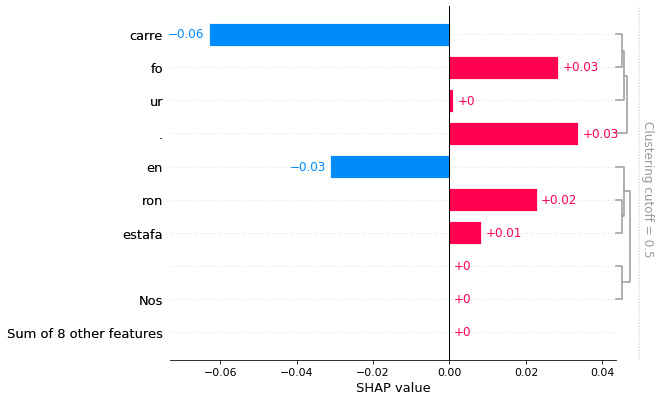

In [55]:
shap.plots.bar(shap_values[:,:,"ALIMENTACION"][0])

En los ejemplos anteriores, explicamos la salida directa del objeto pipline, que son las probabilidades de clase. A veces tiene más sentido trabajar en un espacio de probabilidades logarítmicas donde es natural sumar y restar efectos (la suma y la resta corresponden a la suma o resta de bits de información de evidencia).

In [56]:
logit_explainer = shap.Explainer(shap.models.TransformersPipeline(pred, rescale_to_logits=True))

logit_shap_values = logit_explainer(sample)
shap.plots.text(logit_shap_values)

  0%|          | 0/272 [00:00<?, ?it/s]

Partition explainer: 2it [00:23, 23.99s/it]               
